In [1]:
from pyspark.sql import SparkSession # Entry point 
from pyspark.sql.functions import col # To refer to DataFrame columns later on while applying transformations
from pyspark.sql.types import DoubleType # Defines numeric data types explicitly 
from pyspark.ml.feature import VectorAssembler, StandardScaler # for feature engineering
from pyspark.ml.classification import LogisticRegression # for model training
from pyspark.ml.evaluation import MulticlassClassificationEvaluator # for model evaluation
import matplotlib.pyplot as plt #for data visualization
import seaborn as sns # for data visualization

In [2]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("CHD Prediction with PySpark") \
    .getOrCreate()


In [3]:
# Load dataset
file_path = "framingham.csv"
disease_df = spark.read.csv(file_path, header=True, inferSchema=True) # header=True indicates that the first row contains column names and inferSchema will automatically detect the data type of each column

In [4]:
# Drop the 'education' column
disease_df = disease_df.drop('education')


In [5]:
# Rename column 'male' to 'Sex_male'
disease_df = disease_df.withColumnRenamed('male', 'Sex_male')

In [ ]:


# Check for string-type columns and cast to DoubleType
columns_to_cast = ['cigsPerDay', 'totChol', 'glucose']
for col_name in columns_to_cast:
    disease_df = disease_df.withColumn(col_name, col(col_name).cast(DoubleType())) # ML algos require numeric data types so we're changing CigsPerDay, TotChol, and Glucose to DoubleType

In [7]:
# Verify schema to ensure the columns are now numeric
disease_df.printSchema()

root
 |-- Sex_male: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- currentSmoker: integer (nullable = true)
 |-- cigsPerDay: double (nullable = true)
 |-- BPMeds: string (nullable = true)
 |-- prevalentStroke: integer (nullable = true)
 |-- prevalentHyp: integer (nullable = true)
 |-- diabetes: integer (nullable = true)
 |-- totChol: double (nullable = true)
 |-- sysBP: double (nullable = true)
 |-- diaBP: double (nullable = true)
 |-- BMI: string (nullable = true)
 |-- heartRate: string (nullable = true)
 |-- glucose: double (nullable = true)
 |-- TenYearCHD: integer (nullable = true)



In [8]:
# Remove rows with null values
disease_df = disease_df.na.drop()


In [9]:
# Check the data
disease_df.show(5)
print(f"Dataset shape: {disease_df.count()}, {len(disease_df.columns)}")
disease_df.groupBy('TenYearCHD').count().show()
### this is for displaying the first 5 rows and grouping by the target variable which is TenYearCHD


+--------+---+-------------+----------+------+---------------+------------+--------+-------+-----+-----+-----+---------+-------+----------+
|Sex_male|age|currentSmoker|cigsPerDay|BPMeds|prevalentStroke|prevalentHyp|diabetes|totChol|sysBP|diaBP|  BMI|heartRate|glucose|TenYearCHD|
+--------+---+-------------+----------+------+---------------+------------+--------+-------+-----+-----+-----+---------+-------+----------+
|       1| 39|            0|       0.0|     0|              0|           0|       0|  195.0|106.0| 70.0|26.97|       80|   77.0|         0|
|       0| 46|            0|       0.0|     0|              0|           0|       0|  250.0|121.0| 81.0|28.73|       95|   76.0|         0|
|       1| 48|            1|      20.0|     0|              0|           0|       0|  245.0|127.5| 80.0|25.34|       75|   70.0|         0|
|       0| 61|            1|      30.0|     0|              0|           1|       0|  225.0|150.0| 95.0|28.58|       65|  103.0|         1|
|       0| 46|      

In [10]:
# Features and target variable
feature_columns = ['age', 'Sex_male', 'cigsPerDay', 'totChol', 'sysBP', 'glucose']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
disease_df = assembler.transform(disease_df)

#combines multiple feature columns into a single vector thats relevant to the model

In [11]:
# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(disease_df)
disease_df = scaler_model.transform(disease_df)
# this step improves the performance of the model by standerdizing the feature values to have unit variance (because they're sensitive to varying feature values)

In [12]:
# Select features and target for modeling
data = disease_df.select('scaledFeatures', 'TenYearCHD')

In [13]:
# Train-Test Split
train_data, test_data = data.randomSplit([0.7, 0.3], seed=42) #for evaluating model performance

In [14]:
# Logistic Regression Model
lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='TenYearCHD')
lr_model = lr.fit(train_data)

# logistic Regression is a classification algorithm used to predict categorical data (binary classification)

In [15]:
# Predict on test data
predictions = lr_model.transform(test_data)

# uses the trained model to make predictions on the test data

In [16]:
# Evaluation
evaluator = MulticlassClassificationEvaluator(
    labelCol="TenYearCHD", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy of the model is = {accuracy:.2f}")

#Evaluates the model accuracy using MCE which measures the proportion of correctly classified instances

Accuracy of the model is = 0.85


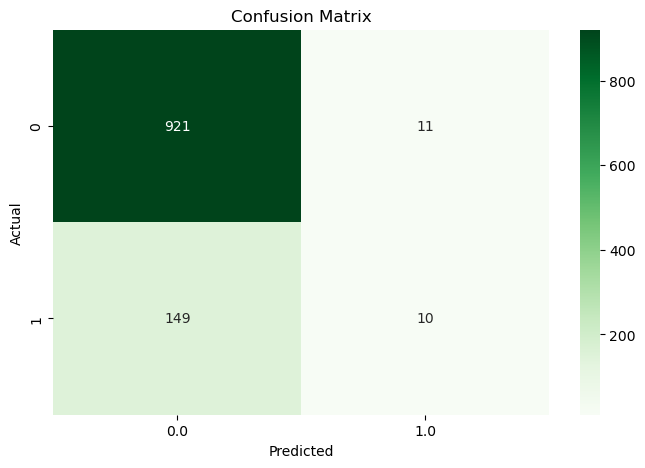

In [17]:
# Confusion Matrix
cm = predictions.groupBy("TenYearCHD", "prediction").count().toPandas()
conf_matrix = cm.pivot(index="TenYearCHD", columns="prediction", values="count").fillna(0)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Greens") 
plt.title('Confusion Matrix') 
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#actual value on the x-axis and predicted value on the y-axis
#actual 0.0 predicted 0.0 TN cases where the actual value is 0.0 (No CHD), and the model correctly predicted 0.0.
#actual 0.0 predicted 1.0 FP cases where the actual value is 0.0 (No CHD), but the model incorrectly predicted 1.0 (CHD).
#actual 1.0 predicted 0.0 FN cases where the actual value is 1.0 (CHD), but the model incorrectly predicted 0.0 (No CHD).
#actual 1.0 predicted 1.0 TP cases where the actual value is 1.0 (CHD), and the model correctly predicted 1.0.